In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def generate_chaotic_data(n_samples=1000, n_features=5, noise_level=0.1, random_state=None):
    """
    Generate chaotic data with better structured non-linear relationships
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    X = np.random.randn(n_samples, n_features) * 2
    
    y = (
        3.0 * np.sin(X[:, 0] / 2) +  
        2.0 * np.cos(X[:, 1] * 1.5) +  
        1.5 * X[:, 2]**2 +  
        1.0 * np.exp(-0.5 * X[:, 3]**2) +  
        0.5 * X[:, 4] +  
        0.5 * X[:, 0] * X[:, 1] +  
        0.3 * np.maximum(X[:, 2], 0)  
    )
    
    noise = np.random.normal(0, noise_level, n_samples)
    y += noise
    
    outlier_idx = np.random.choice(n_samples, size=int(0.01 * n_samples), replace=False)
    y[outlier_idx] += np.random.normal(0, noise_level * 3, len(outlier_idx))
    
    return X, y.reshape(-1, 1)

In [5]:
class MultiLayerPerceptron:
    def __init__(
        self,
        layer_sizes,
        learning_rate=0.01,
        max_epochs=1000,
        activation='sigmoid',
        optimizer='adam',
        weight_init='he',
        batch_size=32,
        dropout_rate=0.0,
        l2_lambda=0.0,
        momentum=0.9,
        early_stopping_patience=10,
        learning_rate_decay=0.0,
        validation_split=0.2
    ):
        """
        Enhanced Multi-Layer Perceptron with modern features
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.activation = activation
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.momentum = momentum
        self.early_stopping_patience = early_stopping_patience
        self.learning_rate_decay = learning_rate_decay
        self.validation_split = validation_split
        
        self._initialize_parameters()
        self._initialize_optimizer()
        
        self.training_loss = []
        self.validation_loss = []
        self.best_validation_loss = float('inf')
        self.patience_counter = 0
    
    def _standardize_data(self, X, X_val=None):
        """Standardize the data (zero mean, unit variance)"""
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        
        X_standardized = (X - mean) / (std + 1e-8)
        
        if X_val is not None:
            X_val_standardized = (X_val - mean) / (std + 1e-8)
            return X_standardized, X_val_standardized
            
        return X_standardized
    
    def _train_val_split(self, X, y):
        """Split data into training and validation sets"""
        indices = np.random.permutation(len(X))
        val_size = int(len(X) * self.validation_split)
        
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]
        
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_val = X[val_indices]
        y_val = y[val_indices]
        
        return X_train, X_val, y_train, y_val
        
    def _initialize_parameters(self):
        """Initialize weights and biases using specified initialization method"""
        self.weights = []
        self.biases = []
        self.dropout_masks = []
        
        for i in range(len(self.layer_sizes) - 1):
            if self.weight_init == 'xavier':
                scale = np.sqrt(2.0 / (self.layer_sizes[i] + self.layer_sizes[i+1]))
            else:  
                scale = np.sqrt(2.0 / self.layer_sizes[i])
            
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * scale
            b = np.zeros((1, self.layer_sizes[i+1]))
            
            self.weights.append(w)
            self.biases.append(b)
    
    def _initialize_optimizer(self):
        """Initialize optimizer-specific parameters"""
        self.velocity_w = [np.zeros_like(w) for w in self.weights]
        self.velocity_b = [np.zeros_like(b) for b in self.biases]
        
        if self.optimizer == 'adam':
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        elif self.optimizer == 'rmsprop':
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
    
    def _activation_function(self, x, derivative=False):
        """Enhanced activation function with multiple options"""
        if self.activation == 'sigmoid':
            if not derivative:
                return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            return x * (1 - x)
        elif self.activation == 'tanh':
            if not derivative:
                return np.tanh(x)
            return 1 - np.tanh(x)**2
        elif self.activation == 'relu':
            if not derivative:
                return np.maximum(0, x)
            return (x > 0).astype(float)
        elif self.activation == 'leaky_relu':
            alpha = 0.01
            if not derivative:
                return np.where(x > 0, x, alpha * x)
            return np.where(x > 0, 1, alpha)
    
    def _apply_dropout(self, layer_output, training=True):
        """Apply dropout regularization"""
        if training and self.dropout_rate > 0:
            mask = np.random.binomial(1, 1 - self.dropout_rate, size=layer_output.shape)
            self.dropout_masks.append(mask)
            return layer_output * mask / (1 - self.dropout_rate)
        return layer_output
    
    def forward_propagation(self, X, training=True):
        """Enhanced forward propagation with dropout"""
        self.layer_outputs = []
        self.layer_inputs = []
        self.dropout_masks = []
        
        current_output = X
        
        for i in range(len(self.weights)):
            layer_input = np.dot(current_output, self.weights[i]) + self.biases[i]
            self.layer_inputs.append(layer_input)
            
            current_output = self._activation_function(layer_input)
            current_output = self._apply_dropout(current_output, training)
            self.layer_outputs.append(current_output)
        
        return current_output
    
    def _compute_gradients(self, X, y, output):
        """Compute gradients with L2 regularization"""
        m = X.shape[0]
        delta = output - y
        
        weight_gradients = []
        bias_gradients = []
        
        for i in range(len(self.weights) - 1, -1, -1):
            if i == len(self.weights) - 1:
                delta = delta * self._activation_function(output, derivative=True)
            else:
                delta = np.dot(delta, self.weights[i+1].T) * self._activation_function(self.layer_outputs[i], derivative=True)
                if self.dropout_rate > 0:
                    delta = delta * self.dropout_masks[i] / (1 - self.dropout_rate)
            
            if i == 0:
                weight_grad = np.dot(X.T, delta)
            else:
                weight_grad = np.dot(self.layer_outputs[i-1].T, delta)
            
            weight_grad += self.l2_lambda * self.weights[i]
            
            bias_grad = np.sum(delta, axis=0, keepdims=True)
            
            weight_gradients.insert(0, weight_grad)
            bias_gradients.insert(0, bias_grad)
        
        return weight_gradients, bias_gradients
    
    def _update_parameters(self, weight_gradients, bias_gradients, t):
        """Update parameters using the specified optimizer"""
        if self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.learning_rate * weight_gradients[i]
                self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.learning_rate * bias_gradients[i]
                
                self.weights[i] += self.velocity_w[i]
                self.biases[i] += self.velocity_b[i]
        
        elif self.optimizer == 'adam':
            for i in range(len(self.weights)):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * weight_gradients[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (weight_gradients[i]**2)
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * bias_gradients[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (bias_gradients[i]**2)
                
                m_w_hat = self.m_w[i] / (1 - self.beta1**t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**t)
                m_b_hat = self.m_b[i] / (1 - self.beta1**t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**t)
                
                self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
        
        elif self.optimizer == 'rmsprop':
            for i in range(len(self.weights)):
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (weight_gradients[i]**2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (bias_gradients[i]**2)
                
                self.weights[i] -= self.learning_rate * weight_gradients[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i] -= self.learning_rate * bias_gradients[i] / (np.sqrt(self.v_b[i]) + self.epsilon)
    
    def _get_batches(self, X, y):
        """Create mini-batches from the data"""
        indices = np.random.permutation(X.shape[0])
        for i in range(0, X.shape[0], self.batch_size):
            batch_indices = indices[i:i + self.batch_size]
            yield X[batch_indices], y[batch_indices]
    
    def train(self, X, y, X_val=None, y_val=None):
        """Enhanced training with validation and early stopping"""
        if X_val is None or y_val is None:
            X, X_val, y, y_val = self._train_val_split(X, y)
        
        X, X_val = self._standardize_data(X, X_val)
        
        for epoch in range(self.max_epochs):
            epoch_loss = 0
            batch_count = 0
            
            for batch_X, batch_y in self._get_batches(X, y):
                output = self.forward_propagation(batch_X, training=True)
                weight_gradients, bias_gradients = self._compute_gradients(batch_X, batch_y, output)
                self._update_parameters(weight_gradients, bias_gradients, epoch + 1)
                
                batch_loss = np.mean(np.square(output - batch_y))
                epoch_loss += batch_loss
                batch_count += 1
            
            epoch_loss /= batch_count
            self.training_loss.append(epoch_loss)
            
            val_output = self.forward_propagation(X_val, training=False)
            val_loss = np.mean(np.square(val_output - y_val))
            self.validation_loss.append(val_loss)
            
            self.learning_rate = self.initial_learning_rate / (1 + self.learning_rate_decay * epoch)
            
            if val_loss < self.best_validation_loss:
                self.best_validation_loss = val_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    def predict(self, X):
        """Make predictions"""
        X_standardized = self._standardize_data(X)
        return self.forward_propagation(X_standardized, training=False)
    
    def plot_learning_curves(self):
        """Plot training and validation loss curves"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.training_loss, label='Training Loss')
        plt.plot(self.validation_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Learning Curves')
        plt.legend()
        plt.grid(True)
        plt.show()

In [7]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate various regression metrics from scratch.
    """
    mse = np.mean((y_true - y_pred) ** 2)
    
    rmse = np.sqrt(mse)
    
    mae = np.mean(np.abs(y_true - y_pred))
    
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    var_y_true = np.var(y_true)
    var_error = np.var(y_true - y_pred)
    explained_var = 1 - (var_error / var_y_true)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Explained_Variance': explained_var
    }

def plot_essential_diagnostics(model, X, y_true, y_pred, metrics, history_df=None):
    """
    Create simplified plots focusing on model performance and predictions.
    """
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(221)
    ax1.plot(model.training_loss, label='Training', color='#2ecc71', linewidth=2)
    ax1.plot(model.validation_loss, label='Validation', color='#e74c3c', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training History')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(222)
    ax2.scatter(y_true, y_pred, alpha=0.5, color='#3498db', label='Data Points')
    
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', 
             label='Perfect Prediction', linewidth=2)
    
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    ax2.set_title('Predictions vs Actual')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(223)
    architecture_text = (
        "MODEL ARCHITECTURE\n"
        f"Input Layer:     {model.layer_sizes[0]} neurons\n"
        f"Hidden Layers:   {' → '.join(map(str, model.layer_sizes[1:-1]))}\n"
        f"Output Layer:    {model.layer_sizes[-1]} neuron\n"
        f"Total Params:    {sum(w.size + b.size for w, b in zip(model.weights, model.biases))}\n"
        f"\nHYPERPARAMETERS\n"
        f"Learning Rate:   {model.learning_rate:.6f}\n"
        f"Activation:      {model.activation}\n"
        f"Optimizer:       {model.optimizer}\n"
        f"Batch Size:      {model.batch_size}\n"
        f"Dropout Rate:    {model.dropout_rate}"
    )
    
    ax3.text(0.05, 0.95, architecture_text,
             transform=ax3.transAxes,
             fontsize=10,
             family='monospace',
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=10))
    ax3.axis('off')
    
    ax4 = fig.add_subplot(224)
    metrics_text = (
        "PERFORMANCE METRICS\n\n"
        f"Mean Squared Error (MSE):      {metrics['MSE']:.6f}\n"
        f"Root Mean Squared Error:       {metrics['RMSE']:.6f}\n"
        f"Mean Absolute Error:           {metrics['MAE']:.6f}\n"
        f"R² Score:                      {metrics['R2']:.6f}\n"
        f"Mean Absolute % Error:         {metrics['MAPE']:.2f}%\n"
        f"Explained Variance:            {metrics['Explained_Variance']:.6f}\n"
        f"\nFINAL LOSS VALUES\n"
        f"Training Loss:                 {model.training_loss[-1]:.6f}\n"
        f"Validation Loss:               {model.validation_loss[-1]:.6f}"
    )
    
    ax4.text(0.05, 0.95, metrics_text,
             transform=ax4.transAxes,
             fontsize=10,
             family='monospace',
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=10))
    ax4.axis('off')
    
    plt.tight_layout()
    return fig

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    """
    Train model and display results in a clean format
    """
    print("Training model...")
    
    model = MultiLayerPerceptron(
        layer_sizes=[5, 32, 64, 32, 1],
        learning_rate=0.0005,
        max_epochs=2000,
        activation='leaky_relu',
        optimizer='adam',
        weight_init='he',
        batch_size=64,
        dropout_rate=0.1,
        l2_lambda=0.001,
        momentum=0.9,
        early_stopping_patience=50,
        learning_rate_decay=0.0001,
        validation_split=0.2
    )
    
    # Train
    model.train(X_train, y_train)
    
    print("\nGenerating predictions...")
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    print("\nCalculating metrics...")
    train_metrics = calculate_metrics(y_train, train_predictions)
    test_metrics = calculate_metrics(y_test, test_predictions)
    
    print("\nTRAINING RESULTS:")
    print("-" * 50)
    for metric, value in train_metrics.items():
        print(f"{metric:20} {value:.6f}")
    
    print("\nTEST RESULTS:")
    print("-" * 50)
    for metric, value in test_metrics.items():
        print(f"{metric:20} {value:.6f}")
    
    print("\nGenerating visualization...")
    plot_essential_diagnostics(model, X_test, y_test, test_predictions, test_metrics)
    plt.show()
    
    return model, test_metrics

Training model...
Epoch 0, Training Loss: 102.8303, Validation Loss: 66.4776
Epoch 100, Training Loss: 37.6309, Validation Loss: 13.6850
Epoch 200, Training Loss: 23.2966, Validation Loss: 10.0027
Epoch 300, Training Loss: 22.4209, Validation Loss: 9.1998
Early stopping at epoch 348

Generating predictions...

Calculating metrics...

TRAINING RESULTS:
--------------------------------------------------
MSE                  8.427100
RMSE                 2.902947
MAE                  2.042221
R2                   0.903031
MAPE                 66.581279
Explained_Variance   0.914971

TEST RESULTS:
--------------------------------------------------
MSE                  9.106989
RMSE                 3.017779
MAE                  2.225345
R2                   0.876618
MAPE                 63.580772
Explained_Variance   0.898713

Generating visualization...


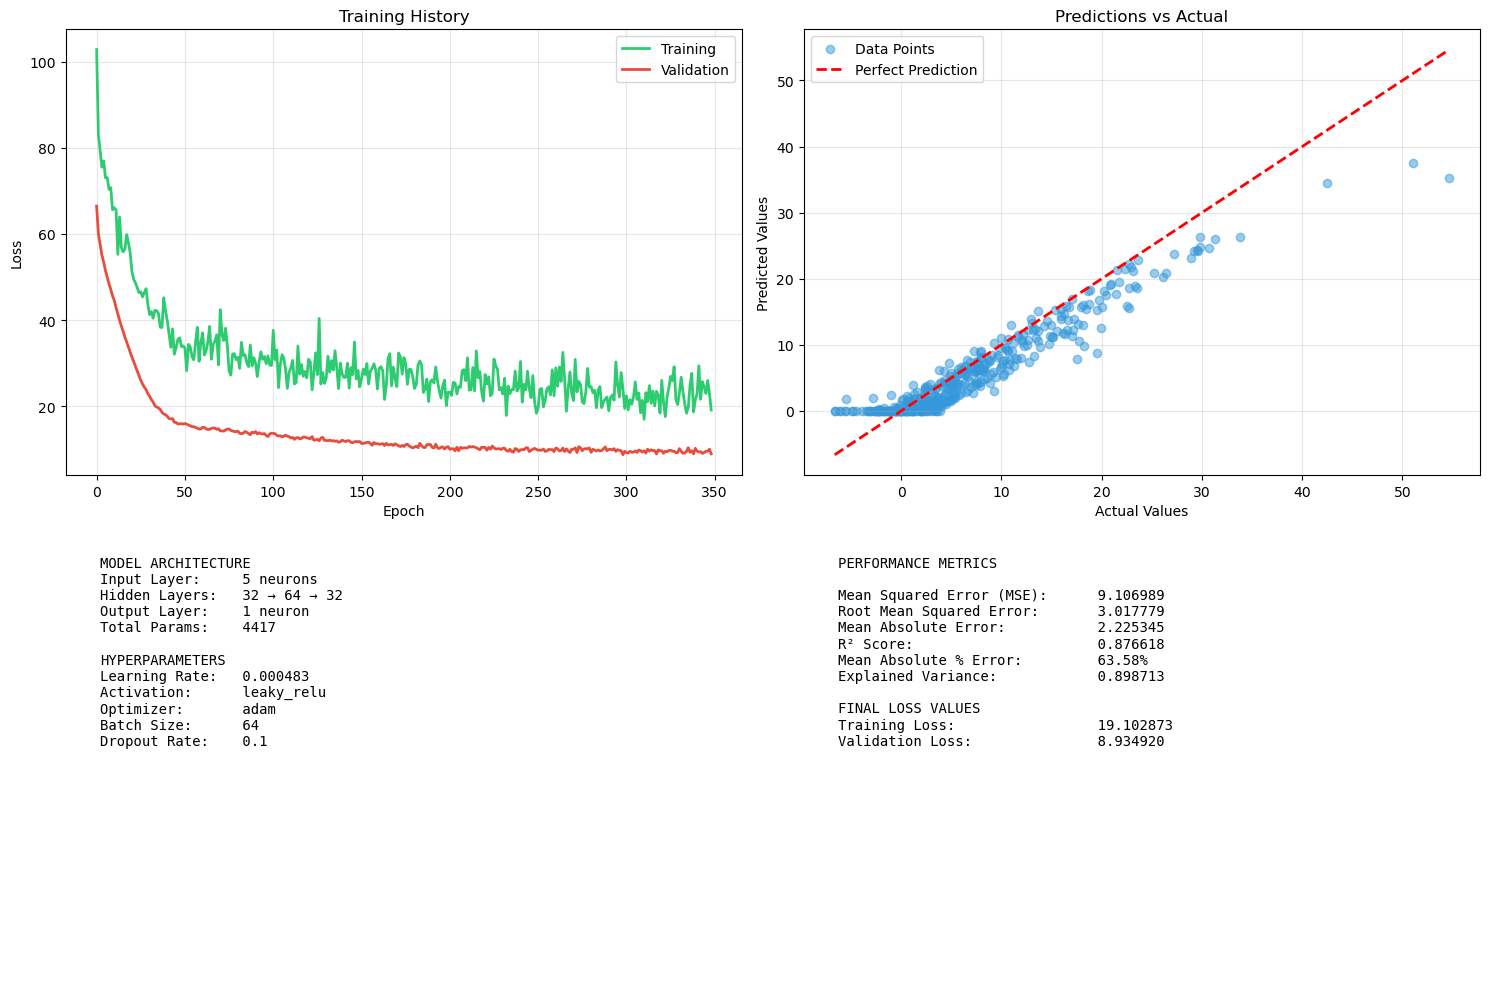

In [9]:
X_train, y_train = generate_chaotic_data(n_samples=2000, noise_level=0.1, random_state=42)
X_test, y_test = generate_chaotic_data(n_samples=400, noise_level=0.1, random_state=43)

model, metrics = train_and_evaluate_model(X_train, y_train, X_test, y_test)

In [10]:
from sklearn.datasets import fetch_california_housing, load_diabetes

def load_benchmark_dataset(dataset_name='california_housing'):
    """
    Load benchmark datasets for regression
    """
    if dataset_name == 'california_housing':
        data = fetch_california_housing()
        X, y = data.data, data.target
        feature_names = data.feature_names
        target_name = "Housing Price"
        description = """
        California Housing Prices Dataset:
        Predicts median house values in California districts
        Features include median income, house age, average rooms,
        average bedrooms, population, average occupancy, latitude, and longitude.
        """
        
    elif dataset_name == 'diabetes':
        data = load_diabetes()
        X, y = data.data, data.target
        feature_names = data.feature_names
        target_name = "Disease Progression"
        description = """
        Diabetes Disease Progression Dataset:
        Predicts disease progression using age, sex, BMI, blood pressure,
        and six blood serum measurements.
        """
    
    dataset_info = {
        'feature_names': feature_names,
        'target_name': target_name,
        'description': description,
        'n_features': X.shape[1],
        'n_samples': X.shape[0]
    }
    
    return X, y.reshape(-1, 1), dataset_info

In [11]:
def train_and_evaluate_model(X, y, dataset_info):
    """
    Train and evaluate model with detailed output
    """
    print("\nDATASET INFORMATION:")
    print("-" * 50)
    print(dataset_info['description'])
    print(f"\nTotal samples: {dataset_info['n_samples']}")
    print(f"Number of features: {dataset_info['n_features']}")
    print(f"Features: {', '.join(dataset_info['feature_names'])}")
    print("\nTraining model...")
    
    model = MultiLayerPerceptron(
        layer_sizes=[dataset_info['n_features'], 64, 32, 16, 1],
        learning_rate=0.001,
        max_epochs=1000,
        activation='leaky_relu',
        optimizer='adam',
        weight_init='he',
        batch_size=32,
        dropout_rate=0.1,
        l2_lambda=0.001,
        momentum=0.9,
        early_stopping_patience=50,
        learning_rate_decay=0.0001,
        validation_split=0.2
    )
    
    model.train(X, y)
    
    print("\nGenerating predictions...")
    train_predictions = model.predict(X)
    metrics = calculate_metrics(y, train_predictions)
    
    print(f"\nMETRICS ({dataset_info['target_name']}):")
    print("-" * 50)
    for metric, value in metrics.items():
        print(f"{metric:20} {value:.6f}")
    
    print("\nGenerating visualization...")
    fig = plot_essential_diagnostics(model, X, y, train_predictions, metrics)
    fig.suptitle(f"Model Performance on {dataset_info['target_name']} Prediction", 
                fontsize=14, y=1.02)
    plt.show()
    
    return model, metrics

In [12]:
def run_benchmark_comparison():
    """
    Run and compare model performance on different datasets
    """
    results = {}
    
    for dataset_name in ['california_housing', 'diabetes']:
        print(f"\nTesting on {dataset_name.replace('_', ' ').title()} dataset...")
        X, y, info = load_benchmark_dataset(dataset_name)
        model, metrics = train_and_evaluate_model(X, y, info)
        results[dataset_name] = metrics
    
    print("\nPERFORMANCE COMPARISON:")
    print("-" * 70)
    print(f"{'Metric':<15} {'California Housing':<25} {'Diabetes':<25}")
    print("-" * 70)
    
    for metric in results['california_housing'].keys():
        cal_value = results['california_housing'][metric]
        diab_value = results['diabetes'][metric]
        print(f"{metric:<15} {cal_value:< 25.6f} {diab_value:< 25.6f}")
    
    return results


Testing on California Housing dataset...

DATASET INFORMATION:
--------------------------------------------------

        California Housing Prices Dataset:
        Predicts median house values in California districts
        Features include median income, house age, average rooms,
        average bedrooms, population, average occupancy, latitude, and longitude.
        

Total samples: 20640
Number of features: 8
Features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude

Training model...
Epoch 0, Training Loss: 1.7020, Validation Loss: 0.7469
Epoch 100, Training Loss: 0.8402, Validation Loss: 0.3950
Epoch 200, Training Loss: 0.8192, Validation Loss: 0.3342
Early stopping at epoch 216

Generating predictions...

METRICS (Housing Price):
--------------------------------------------------
MSE                  0.305456
RMSE                 0.552680
MAE                  0.369122
R2                   0.770602
MAPE                 18.062837
Explained_Vari

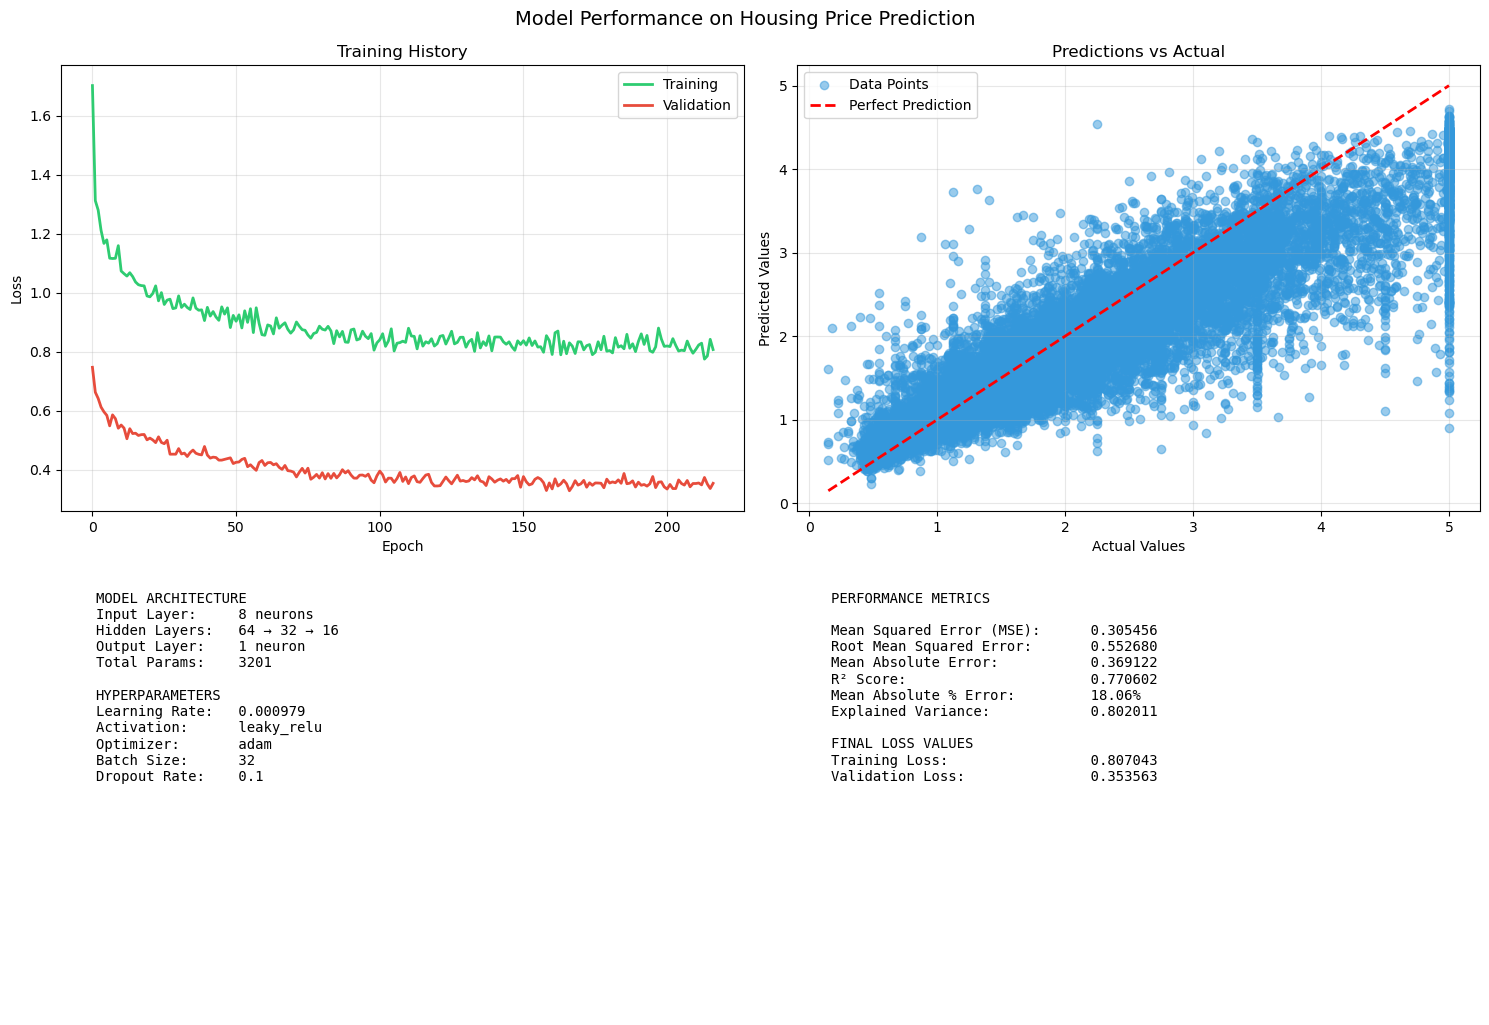


Testing on Diabetes dataset...

DATASET INFORMATION:
--------------------------------------------------

        Diabetes Disease Progression Dataset:
        Predicts disease progression using age, sex, BMI, blood pressure,
        and six blood serum measurements.
        

Total samples: 442
Number of features: 10
Features: age, sex, bmi, bp, s1, s2, s3, s4, s5, s6

Training model...
Epoch 0, Training Loss: 30229.3181, Validation Loss: 25419.1279
Epoch 100, Training Loss: 6700.8721, Validation Loss: 3332.6556
Epoch 200, Training Loss: 5662.9959, Validation Loss: 3214.4860
Early stopping at epoch 242

Generating predictions...

METRICS (Disease Progression):
--------------------------------------------------
MSE                  2904.551495
RMSE                 53.893891
MAE                  41.838939
R2                   0.510184
MAPE                 31.759793
Explained_Variance   0.560179

Generating visualization...


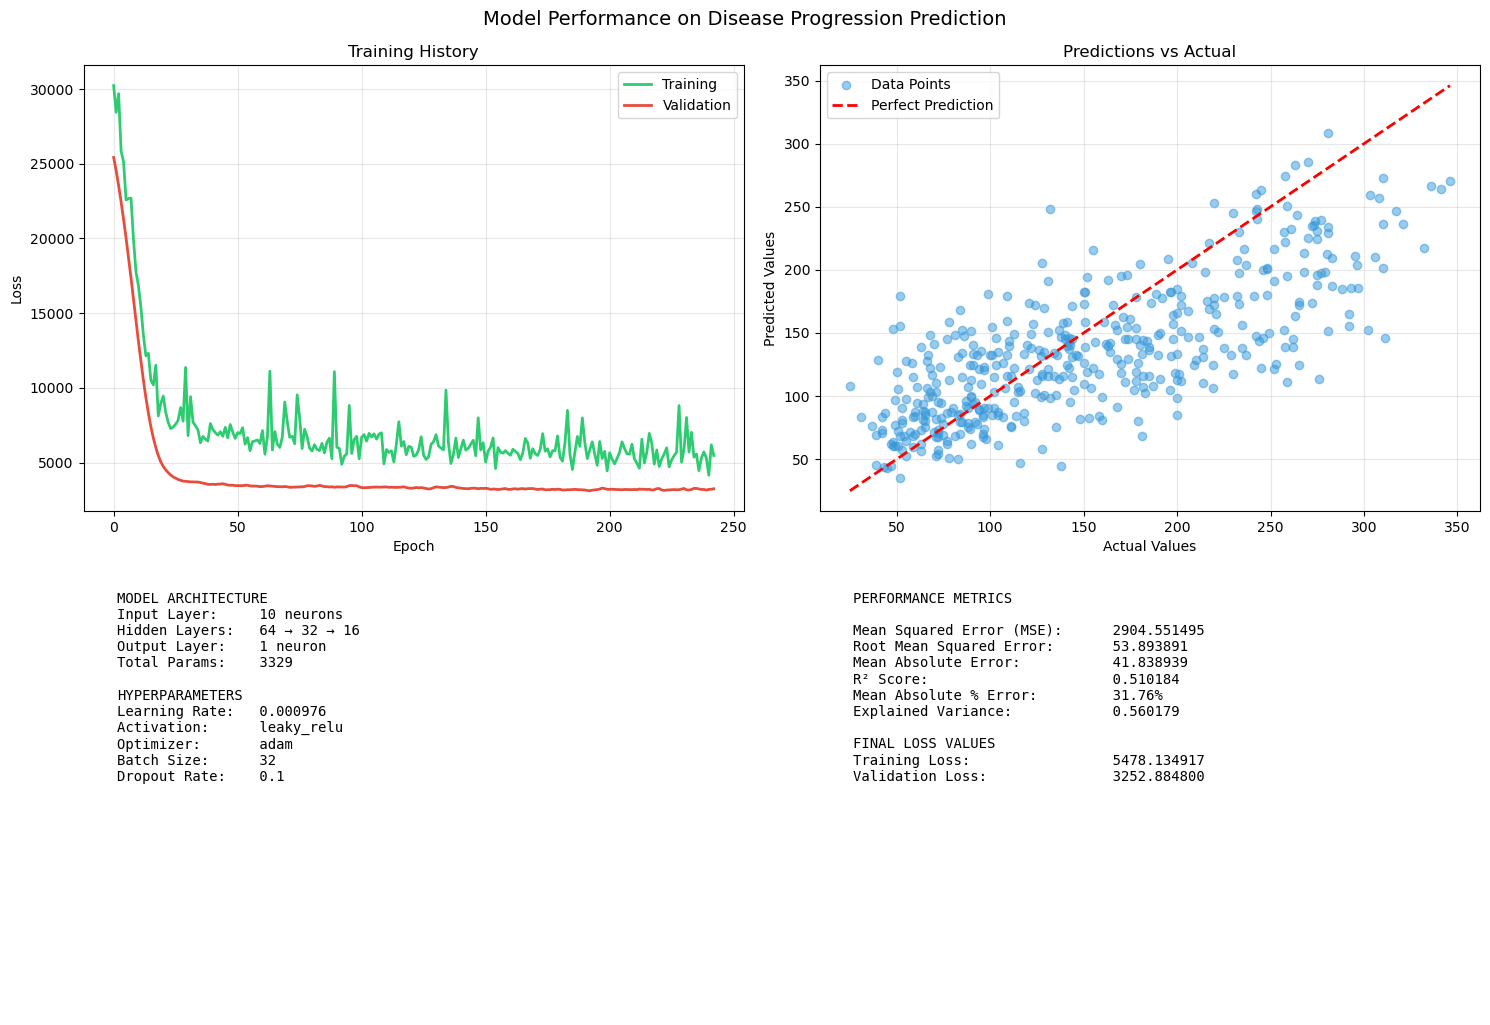


PERFORMANCE COMPARISON:
----------------------------------------------------------------------
Metric          California Housing        Diabetes                 
----------------------------------------------------------------------
MSE              0.305456                  2904.551495             
RMSE             0.552680                  53.893891               
MAE              0.369122                  41.838939               
R2               0.770602                  0.510184                
MAPE             18.062837                 31.759793               
Explained_Variance  0.802011                  0.560179                


In [13]:
results = run_benchmark_comparison()